# Modele de regression supervisé

In [1]:
#pip install "pandas=2.2.2"

In [2]:
import pandas as pd

## Chargement des données

In [3]:
df = pd.read_csv('appartements_data.csv')

### Verification du type et de la structure du DataFrame

In [4]:
df.head()

,title,price,city_name,salon,nb_rooms,nb_baths,surface_area,equipment,link
0,CMN-MA-1752 - Appartement à vendre à Palmier,2 000 000 DH,Casablanca,NaN,2.0,2.0,168.0,Ascenseur/Balcon/Parking/Terrasse,https://www.avito.ma/fr/palmier/appartements/C...
1,66370-Vente Appt à Casablanca Hay Hassani de 1...,1 195 000 DH,Casablanca,NaN,2.0,2.0,98.0,Ascenseur/Balcon/Chauffage/Climatisation/Cuisi...,https://www.avito.ma/fr/hay_hassani/appartemen...
2,Appartement à vendre 81 m² à Dar Bouazza,1 350 000 DH,Dar Bouazza,1.0,2.0,2.0,81.0,Ascenseur/Balcon/Chauffage/Climatisation/Conci...,https://www.avito.ma/fr/dar_bouazza/appartemen...
3,63860-Vente Appt à Casablanca Quartier Bd Med ...,900 000 DH,Casablanca,NaN,1.0,1.0,56.0,Ascenseur/Chauffage/Climatisation/Cuisine Équi...,https://www.avito.ma/fr/centre_ville/apparteme...
4,Appartement à Rabat Agdal,3 100 000 DH,Rabat,2.0,3.0,2.0,200.0,Ascenseur/Balcon/Concierge/Parking/Sécurité,https://www.avito.ma/fr/agdal/appartements/App...


In [5]:
df_sous = df.head().copy()

# Analyse exploratoire des données

In [6]:
df_sous.dtypes

title            object
price            object
city_name        object
salon           float64
nb_rooms        float64
nb_baths        float64
surface_area    float64
equipment        object
link             object
dtype: object

In [7]:
df_sous.size

45

## Verification des duplications

In [8]:
df_sous.duplicated().sum()

np.int64(0)

## Identification des valeurs manquantes

In [9]:
df_sous.isna().any(axis=1).sum()

np.int64(3)

## Analyser la distribution des variables numeriques

In [10]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

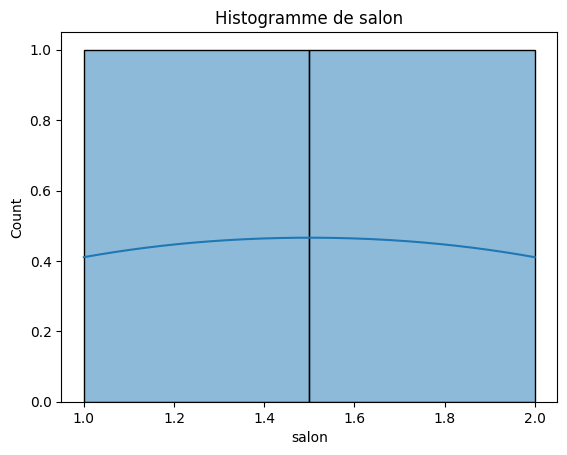

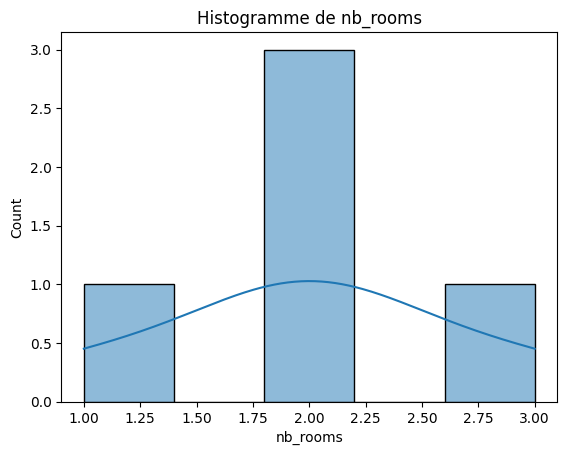

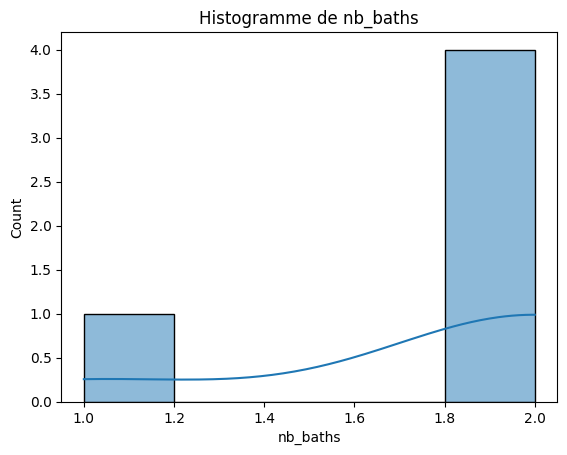

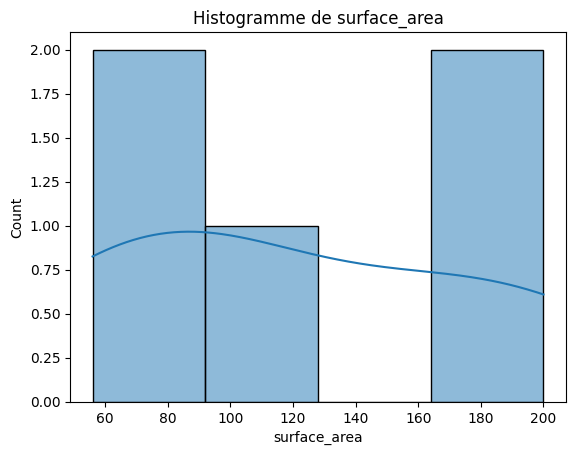

In [12]:
for i in list(df_sous.select_dtypes(include='number').columns):
    sns.histplot(df_sous[i], kde=True)
    plt.title(f'Histogramme de {i}')
    plt.show()

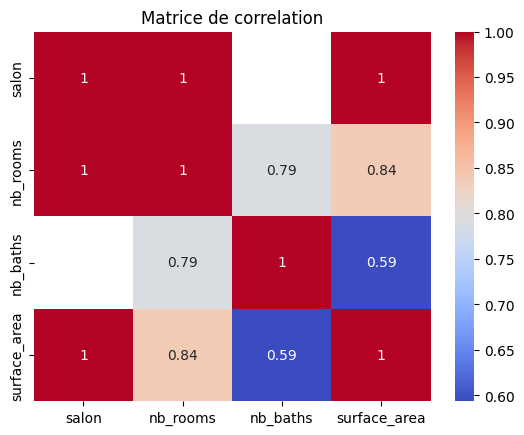

In [13]:
corr = df_sous.corr(numeric_only = True)
sns.heatmap(corr, annot = True, cmap="coolwarm")
plt.title("Matrice de correlation")
plt.show()

# Prétraitement des données

## Etraction des equipements(equipement) dans les colonnes booléeenne

In [14]:
equipement_dummies = df_sous["equipment"].str.get_dummies(sep='/')
df_sous = pd.concat([df_sous, equipement_dummies], axis=1)

## Convertion de la colonne price en type float et suppression des caractères non numérique

In [15]:
df_sous["price"] = (df["price"].astype(str).str.replace(r'[^\d]',"", regex=True).replace("", None).astype(float))

##  Supprission les colonnes inutiles telles que equipment et link.

In [16]:
df_droped = df_sous.drop(columns = {"equipment", "link"} , axis=1)

## Traitement de la colonne city_name

In [17]:
df_droped["city_name"].str.strip().str.title()

0     Casablanca
1     Casablanca
2    Dar Bouazza
3     Casablanca
4          Rabat
Name: city_name, dtype: object

## Remplacement des valeurs manquantes dans city_name par "Unknown".

In [18]:
if df_droped["city_name"].isna().any(axis=0).sum() > 0:
    df_droped["city_name"] = df_droped["city_name"].fillna("Unknown")

## Gestion des valeurs manquantes:

## Remplacement les valeurs manquantes par la médiane.

In [19]:
for i in list(df_droped.select_dtypes(include="number").columns):
    df_droped[i] = df_droped[i].fillna(df_droped[i].median())

In [20]:
df_droped.head()

,title,price,city_name,salon,nb_rooms,nb_baths,surface_area,Ascenseur,Balcon,Chauffage,Climatisation,Concierge,Cuisine Équipée,Duplex,Meublé,Parking,Sécurité,Terrasse
0,CMN-MA-1752 - Appartement à vendre à Palmier,2000000.0,Casablanca,1.5,2.0,2.0,168.0,1,1,0,0,0,0,0,0,1,0,1
1,66370-Vente Appt à Casablanca Hay Hassani de 1...,1195000.0,Casablanca,1.5,2.0,2.0,98.0,1,1,1,1,0,1,0,0,1,0,0
2,Appartement à vendre 81 m² à Dar Bouazza,1350000.0,Dar Bouazza,1.0,2.0,2.0,81.0,1,1,1,1,1,1,1,0,1,1,1
3,63860-Vente Appt à Casablanca Quartier Bd Med ...,900000.0,Casablanca,1.5,1.0,1.0,56.0,1,0,1,1,0,1,0,1,1,1,1
4,Appartement à Rabat Agdal,3100000.0,Rabat,2.0,3.0,2.0,200.0,1,1,0,0,1,0,0,0,1,1,0


## Pour les colonnes catégorielles (chaînes de caractères) : imputer avec "Unknown"

In [21]:
for i in df_droped.select_dtypes(include="object").columns:
    df_droped[i] = df_droped[i].fillna("Unkown")

# Détection et suppression des valeurs aberrantes:

## Détection les outliers avec la methode statistique IQR

In [22]:
def outliers(dframe):
    outlier_ = {}
    for i in list(dframe.select_dtypes(include="number").columns):
        q1 = dframe[i].quantile(0.25)
        q3 = dframe[i].quantile(0.75)
        IQR = q1 - q3
        b_basse = q1 - 1.5*IQR
        b_haute = q3 + 1.5*IQR
        outliers = dframe[(dframe[i] < b_basse) | (dframe[i] > b_haute)]

    if not outliers.empty:
        outlier_ = outliers
    return outlier_
 
outliers(df_droped)

,title,price,city_name,salon,nb_rooms,nb_baths,surface_area,Ascenseur,Balcon,Chauffage,Climatisation,Concierge,Cuisine Équipée,Duplex,Meublé,Parking,Sécurité,Terrasse
0,CMN-MA-1752 - Appartement à vendre à Palmier,2000000.0,Casablanca,1.5,2.0,2.0,168.0,1,1,0,0,0,0,0,0,1,0,1
1,66370-Vente Appt à Casablanca Hay Hassani de 1...,1195000.0,Casablanca,1.5,2.0,2.0,98.0,1,1,1,1,0,1,0,0,1,0,0
2,Appartement à vendre 81 m² à Dar Bouazza,1350000.0,Dar Bouazza,1.0,2.0,2.0,81.0,1,1,1,1,1,1,1,0,1,1,1
3,63860-Vente Appt à Casablanca Quartier Bd Med ...,900000.0,Casablanca,1.5,1.0,1.0,56.0,1,0,1,1,0,1,0,1,1,1,1
4,Appartement à Rabat Agdal,3100000.0,Rabat,2.0,3.0,2.0,200.0,1,1,0,0,1,0,0,0,1,1,0


## Suppression des lignes contenant des valeurs aberrantes sur des colonnes clés

In [23]:
def drop_outliers(dframe):
    outlier_ = {}
    for i in list(dframe.select_dtypes(include="number").columns):
        q1 = dframe[i].quantile(0.25)
        q3 = dframe[i].quantile(0.75)
        IQR = q1 - q3
        b_basse = q1 - 1.5*IQR
        b_haute = q3 + 1.5*IQR
        outliers = dframe[(dframe[i] >= b_basse) | (dframe[i] <= b_haute)]

    if not outliers.empty:
        outlier_ = outliers
    return outlier_


df_clean = outliers(df_droped)


In [25]:
df_clean.tail()

,title,price,city_name,salon,nb_rooms,nb_baths,surface_area,Ascenseur,Balcon,Chauffage,Climatisation,Concierge,Cuisine Équipée,Duplex,Meublé,Parking,Sécurité,Terrasse
0,CMN-MA-1752 - Appartement à vendre à Palmier,2000000.0,Casablanca,1.5,2.0,2.0,168.0,1,1,0,0,0,0,0,0,1,0,1
1,66370-Vente Appt à Casablanca Hay Hassani de 1...,1195000.0,Casablanca,1.5,2.0,2.0,98.0,1,1,1,1,0,1,0,0,1,0,0
2,Appartement à vendre 81 m² à Dar Bouazza,1350000.0,Dar Bouazza,1.0,2.0,2.0,81.0,1,1,1,1,1,1,1,0,1,1,1
3,63860-Vente Appt à Casablanca Quartier Bd Med ...,900000.0,Casablanca,1.5,1.0,1.0,56.0,1,0,1,1,0,1,0,1,1,1,1
4,Appartement à Rabat Agdal,3100000.0,Rabat,2.0,3.0,2.0,200.0,1,1,0,0,1,0,0,0,1,1,0
